TD2: SECOM Data Set

Donnée provenant de: https://archive.ics.uci.edu/ml/datasets/secom

#Version 0.1 -- 27/11/2019


In [0]:
# Import libraries 
import os

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from scipy import stats
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split as tts
from sklearn.svm import SVC 

from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NeighbourhoodCleaningRule
from imblearn.under_sampling import TomekLinks
from imblearn.pipeline import Pipeline as ImbPipe
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score, classification_report
from past.builtins import xrange

from IPython.display import Image
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter
from time import time
from __future__ import division
import warnings
warnings.filterwarnings("ignore")

#plt.style.use('ggplot')
#RANDOM_STATE = 42

## **I. LOAD DATA**


In [0]:
#Get the data from URL and keep in a dataframe
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data"
names = ["V" + str(x) for x in range(1, 591)]
dfsecom = pd.read_csv(url, sep=" ", names=names, na_values = "NaN") 
  
url_l = "https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data"
dflabels = pd.read_csv(url_l,sep=" ",names = ["classification","date"],parse_dates = ["date"],na_values = "NaN")

In [13]:
#Describe the dataframe
dfsecom.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,...,V551,V552,V553,V554,V555,V556,V557,V558,V559,V560,V561,V562,V563,V564,V565,V566,V567,V568,V569,V570,V571,V572,V573,V574,V575,V576,V577,V578,V579,V580,V581,V582,V583,V584,V585,V586,V587,V588,V589,V590
count,1561.000000,1560.000000,1553.000000,1553.000000,1553.000000,1553.0,1553.000000,1558.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1564.0,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1557.000000,1567.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,...,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000,1566.000000,1566.000000,1566.000000,1566.000000,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,618.000000,618.000000,618.000000,618.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000
mean,3014.452896,2495.850231,2200.547318,1396.376627,4.197013,100.0,101.112908,0.121822,1.462862,-0.000841,0.000146,0.964353,199.956809,0.0,9.005371,413.086035,9.907603,0.971444,190.047354,12.481034,1.405054,-5618.393610,2699.378435,-3806.299734,-298.598136,1.203845,1.938477,6.638628,69.499532,2.366197,0.184159,3.673189,85.337469,8.960279,50.582639,64.555787,49.417370,66.221274,86.836577,118.679554,...,17.013313,1.230712,0.276688,7.703874,0.503657,57.746537,4.216905,1.623070,0.995009,0.325708,0.072443,32.284956,262.729683,0.679641,6.444985,0.145610,2.610870,0.060086,2.452417,21.117674,530.523623,2.101836,28.450165,0.345636,9.162315,0.104729,5.563747,16.642363,0.021615,0.016829,0.005396,97.934373,0.500096,0.015318,0.003847,3.067826,0.021458,0.016475,0.005283,99.670066
std,73.621787,80.407705,29.513152,441.691640,56.355540,0.0,6.237214,0.008961,0.073897,0.015116,0.009302,0.012452,3.257276,0.0,2.796596,17.221095,2.403867,0.012062,2.781041,0.217965,0.016737,626.822178,295.498535,1380.162148,2902.690117,0.177600,0.189495,1.244249,3.461181,0.408694,0.032944,0.535322,2.026549,1.344456,1.182618,2.574749,1.182619,0.304141,0.446756,1.807221,...,4.966954,1.361117,0.276231,2.192647,0.598852,35.207552,1.280008,1.870433,0.083860,0.201392,0.051578,19.026081,7.630585,0.121758,2.633583,0.081122,1.032761,0.032761,0.996644,10.213294,17.499736,0.275112,86.304681,0.248478,26.920150,0.067791,16.921369,12.485267,0.011730,0.009640,0.003116,87.520966,0.003404,0.017180,0.003720,3.578033,0.012358,0.008808,0.002867,93.891919
min,2743.240000,2158.750000,2060.660000,0.000000,0.681500,100.0,82.131100,0.000000,1.191000,-0.053400,-0.034900,0.655400,182.094000,0.0,2.249300,333.448600,4.469600,0.579400,169.177400,9.877300,1.179700,-7150.250000,0.000000,-9986.750000,-14804.500000,0.000000,0.000000,0.000000,59.400000,0.666700,0.034100,2.069800,83.182900,7.603200,49.834800,63.677400,40.228900,64.919300,84.732700,111.712800,...,6.110000,0.120000,0.018700,2.786000,0.052000,4.826900,1.496700,0.164600,0.891900,0.069900,0.017700,7.236900,242.286000,0.304900,0.970000,0.022400,0.412200,0.009100,0.370600,3.250400,317.196400,0.980200,3.540000,0.066700,1.039500,0.023000,0.663600,4.582000,-0.016900,0.003200,0.001000,0.000000,0.477800,0.006000,0.001700,1.197500,-0.016900,0.003200,0.001000,0.000000
25%,2966.260000,2452.247500,2181.044400,1081.875800,1.017700,100.0,97.920000,0.121100,1.411200,-0.010800,-0.005600,0.958100,198.130700,0.0,7.094875,406.127400,9.567625,0.968200,188.299825,12.460000,1.396500,-5933.250000,2578.000000,-4371.750000,-1476.000000,1.094800,1.906500,5.263700,67.377800,2.088900,0.161700,3.362700,84.490500,8.580000,50.252350,64.024800,49.421200,66.040650,86.578300,118.0156

In [14]:

#1. Combine the two datasets
df = pd.merge(dfsecom, dflabels,left_index=True,right_index=True)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,...,V553,V554,V555,V556,V557,V558,V559,V560,V561,V562,V563,V564,V565,V566,V567,V568,V569,V570,V571,V572,V573,V574,V575,V576,V577,V578,V579,V580,V581,V582,V583,V584,V585,V586,V587,V588,V589,V590,classification,date
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,-0.0034,0.9455,202.4396,0.0,7.9558,414.8710,10.0433,0.9680,192.3963,12.5190,1.4026,-5419.00,2916.50,-4043.75,751.00,0.8955,1.7730,3.0490,64.2333,2.0222,0.1632,3.5191,83.3971,9.5126,50.6170,64.2588,49.3830,66.3141,86.9555,117.5132,...,0.1827,5.7349,0.3363,39.8842,3.2687,1.0297,1.0344,0.4385,0.1039,42.3877,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,533.8500,2.1113,8.95,0.3157,3.0624,0.1026,1.6765,14.9509,NaN,NaN,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1,2008-07-19 11:55:00
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,-0.0148,0.9627,200.5470,0.0,10.1548,414.7347,9.2599,0.9701,191.2872,12.4608,1.3825,-5441.50,2604.25,-3498.75,-1640.25,1.2973,2.0143,7.3900,68.4222,2.2667,0.2102,3.4171,84.9052,9.7997,50.6596,64.2828,49.3404,64.9193,87.5241,118.1188,...,0.2829,7.1196,0.4989,53.1836,3.9139,1.7819,0.9634,0.1745,0.0375,18.1087,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,535.0164,2.4335,5.92,0.2653,2.0111,0.0772,1.1065,10.9003,0.0096,0.0201,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1,2008-07-19 12:32:00
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,0.0013,0.9615,202.0179,0.0,9.5157,416.7075,9.3144,0.9674,192.7035,12.5404,1.4123,-5447.75,2701.75,-4047.00,-1916.50,1.3122,2.0295,7.5788,67.1333,2.3333,0.1734,3.5986,84.7569,8.6590,50.1530,64.1114,49.8470,65.8389,84.7327,118.6128,...,0.0857,7.1619,0.3752,23.0713,3.9306,1.1386,1.5021,0.3718,0.1233,24.7524,267.064,0.9032,1.10,0.6219,0.4122,0.2562,0.4119,68.8489,535.0245,2.0293,11.21,0.1882,4.0923,0.0640,2.0952,9.2721,0.0584,0.0484,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1,2008-07-19 13:17:00
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,-0.0033,0.9629,201.8482,0.0,9.6052,422.2894,9.6924,0.9687,192.1557,12.4782,1.4011,-5468.25,2648.25,-4515.00,-1657.25,1.3137,2.0038,7.3145,62.9333,2.6444,0.2071,3.3813,84.9105,8.6789,50.5100,64.1125,49.4900,65.1951,86.6867,117.0442,...,0.6812,56.9303,17.4781,161.4081,35.3198,54.2917,1.1613,0.7288,0.2710,62.7572,268.228,0.6511,7.32,0.1630,3.5611,0.0670,2.7290,25.0363,530.5682,2.0253,9.33,0.1738,2.8971,0.0525,1.7585,8.5831,0.0202,0.0149,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1,2008-07-19 14:43:00
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,-0.0072,0.9569,201.9424,0.0,10.5661,420.5925,10.3387,0.9735,191.6037,12.4735,1.3888,-5476.25,2635.25,-3987.50,117.00,1.2887,1.9912,7.2748,62.8333,3.1556,0.2696,3.2728,86.3269,8.7677,50.2480,64.1511,49.7520,66.1542,86.1468,121.4364,...,0.4287,9.7608,0.8311,70.9706,4.9086,2.5014,0.9778,0.2156,0.0461,22.0500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532.0155,2.0275,8.83,0.2224,3.1776,0.0706,1.6597,10.9698,NaN,NaN,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1,2008-07-19 15:22:00


In [7]:
df.shape

(1567, 592)

In [8]:
df.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       ...
       'V583', 'V584', 'V585', 'V586', 'V587', 'V588', 'V589', 'V590',
       'classification', 'date'],
      dtype='object', length=592)

## **II. PREPROCESSING**

In [15]:
# Vérification of NaN per colonne
df.isnull().any().any()

True

In [16]:
data = df.copy() #backup (copy) dataframe to 'data'
df.isna().sum()

V1                 6
V2                 7
V3                14
V4                14
V5                14
                  ..
V588               1
V589               1
V590               1
classification     0
date               0
Length: 592, dtype: int64

In [17]:
#Replace NaN with 0
df = df.replace(np.NaN, 0)

#Once again, check them up
df.isnull().any().any()

False

Note: Now the data is clean.

In [12]:
# Fast Statitics 
df.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,...,V552,V553,V554,V555,V556,V557,V558,V559,V560,V561,V562,V563,V564,V565,V566,V567,V568,V569,V570,V571,V572,V573,V574,V575,V576,V577,V578,V579,V580,V581,V582,V583,V584,V585,V586,V587,V588,V589,V590,classification
count,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.0,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,...,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000
mean,3002.910638,2484.700932,2180.887035,1383.901023,4.159516,99.106573,100.209538,0.121122,1.460995,-0.000840,0.000146,0.963122,199.701600,0.0,8.988130,412.295188,9.888635,0.969584,189.683511,12.401385,1.405054,-5611.222719,2695.933153,-3801.441661,-298.217028,1.202308,1.936003,6.630155,69.410828,2.363177,0.183924,3.668501,85.283010,8.954560,50.550359,64.514590,49.385834,66.179014,86.781161,118.603818,...,1.026509,0.230779,6.425630,0.420090,48.165108,3.517227,1.353767,0.994374,0.325500,0.072397,32.264353,216.957377,0.561235,5.322151,0.120242,2.156008,0.049618,2.025161,17.438590,530.523623,2.101836,28.450165,0.345636,9.162315,0.104729,5.563747,16.642363,0.008524,0.006637,0.002128,38.623767,0.499777,0.015308,0.003844,3.065869,0.021445,0.016464,0.005280,99.606461,-0.867262
std,200.204648,184.815753,209.206773,458.937272,56.104457,9.412812,11.363940,0.012831,0.090461,0.015107,0.009296,0.036620,7.848224,0.0,2.821529,24.945317,2.440326,0.044155,8.762332,1.017643,0.016737,657.774591,310.647785,1385.963301,2900.855558,0.182620,0.201632,1.265856,4.257396,0.417084,0.033573,0.550829,2.958325,1.362954,1.740832,3.047065,1.719341,1.700279,2.238656,3.500339,...,1.324688,0.272464,3.496892,0.578109,38.672384,1.956756,1.811760,0.087520,0.201496,0.051594,19.037484,99.925253,0.280600,3.421456,0.092119,1.364539,0.037496,1.298442,12.260744,17.499736,0.275112,86.304681,0.248478,26.920150,0.067791,16.921369,12.485267,0.012879,0.010213,0.003284,72.871466,0.013084,0.017179,0.003721,3.577730,0.012366,0.008815,0.002869,93.895701,0.498010
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.053400,-0.034900,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.179700,-7150.250000,0.000000,-9986.750000,-14804.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,317.196400,0.980200,3.540000,0.066700,1.039500,0.023000,0.663600,4.582000,-0.016900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.016900,0.000000,0.000000,0.000000,-1.000000
25%,2965.670000,2451.515000,2180.700000,1080.116050,1.011000,100.000000,97.762200,0.121100,1.410950,-0.010800,-0.005600,0.958000,198.128450,0.0,7.080300,406.092900,9.565100,0.968100,188.291900,12.460000,1.396500,-5932.625000,2577.875000,-4370.625000,-1474.375000,1.093900,1.906150,5.262400,67.377800,2.088900,0.161700,3.362300,84.484350,8.580000,50.251500,64.024800,49.420500,66.040500,86.

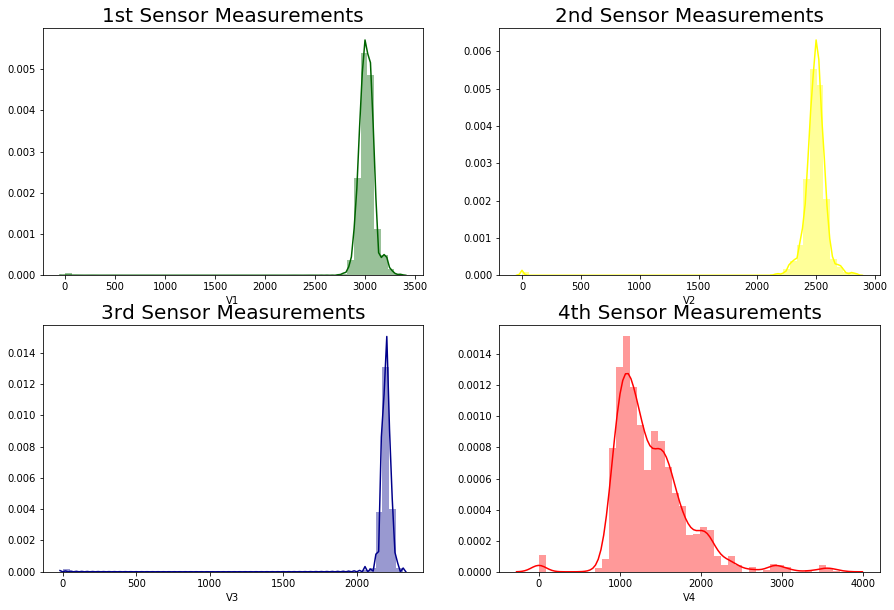

In [19]:
# distribution plot to see 1-4 column's distribution

plt.rcParams['figure.figsize'] = (15, 10)

plt.subplot(2, 2, 1)
sns.distplot(df['V1'], color = 'darkgreen')
plt.title('1st Sensor Measurements', fontsize = 20)

plt.subplot(2, 2, 2)
sns.distplot(df['V2'], color = 'yellow')
plt.title('2nd Sensor Measurements', fontsize = 20)

plt.subplot(2, 2, 3)
sns.distplot(df['V3'], color = 'darkblue')
plt.title('3rd Sensor Measurements', fontsize = 20)

plt.subplot(2, 2, 4)
sns.distplot(df['V4'], color = 'red')
plt.title('4th Sensor Measurements', fontsize = 20)

plt.show()

Text(0.5, 1, 'Heatmap for the Data')

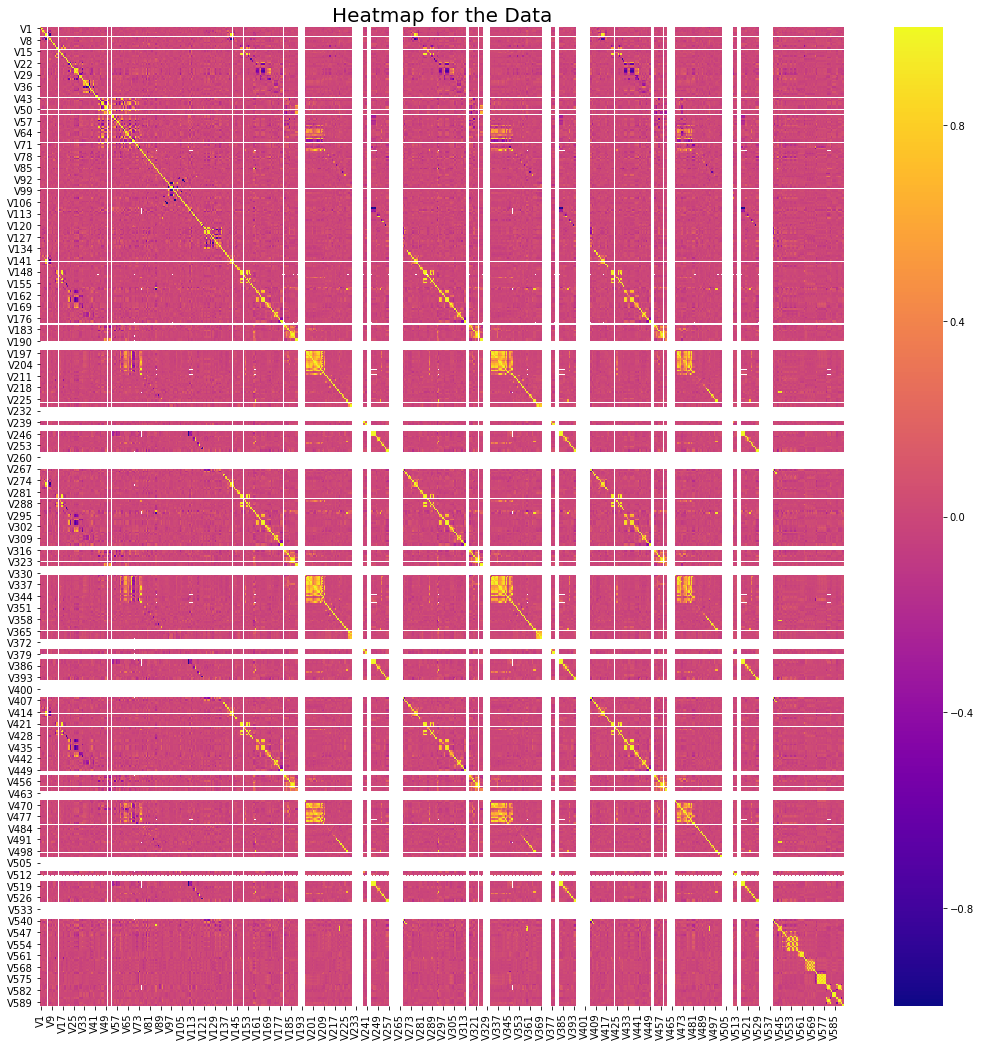

In [20]:
# Heatmap
plt.rcParams['figure.figsize'] = (18, 18)
sns.heatmap(data.corr(), cmap = 'plasma')
plt.title('Heatmap for the Data', fontsize = 20)

In [21]:
#Create Training and Test Sets
from sklearn.model_selection import train_test_split
df2 = df.drop(columns = ['date'], axis = 1) 
print(df.shape)
print(df2.shape)

(1567, 592)
(1567, 591)


In [22]:
df2.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       ...
       'V582', 'V583', 'V584', 'V585', 'V586', 'V587', 'V588', 'V589', 'V590',
       'classification'],
      dtype='object', length=591)

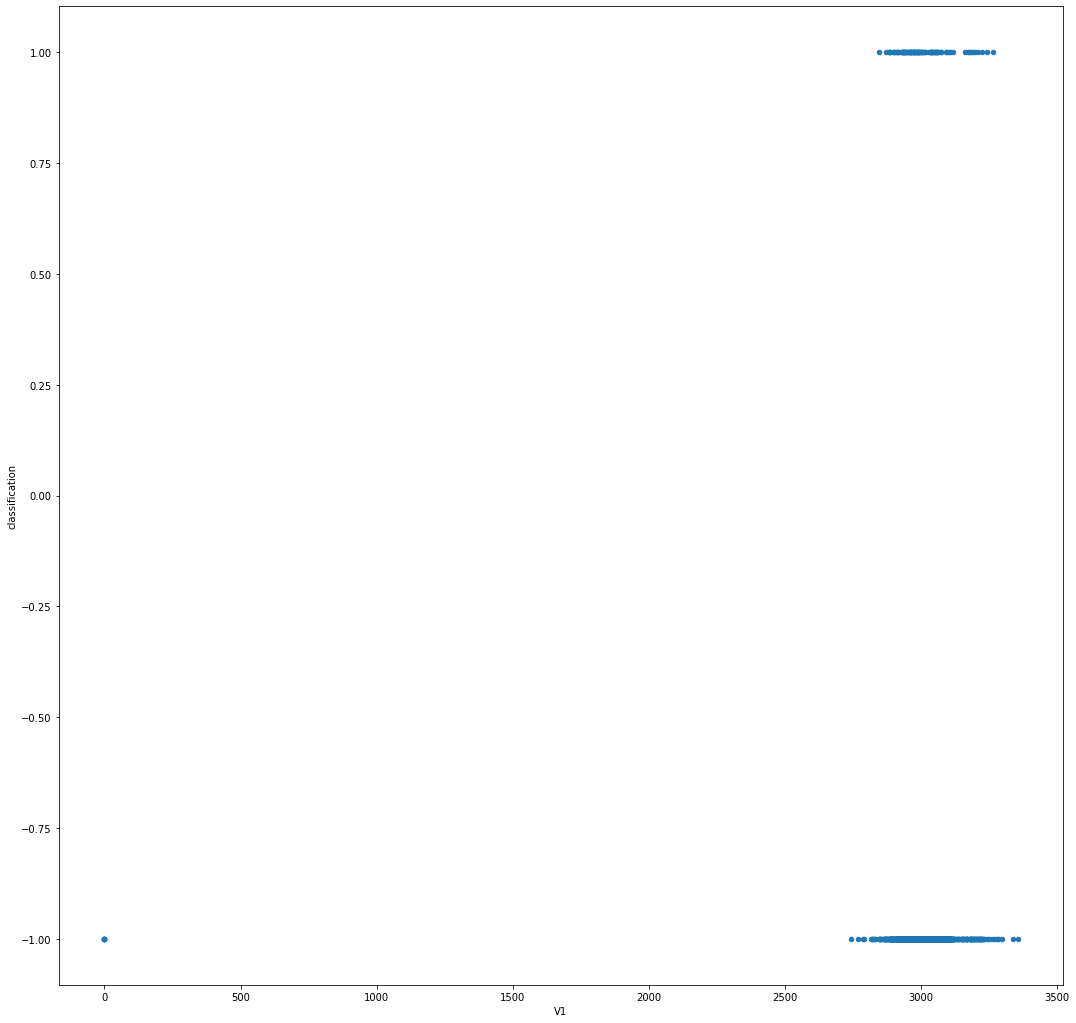

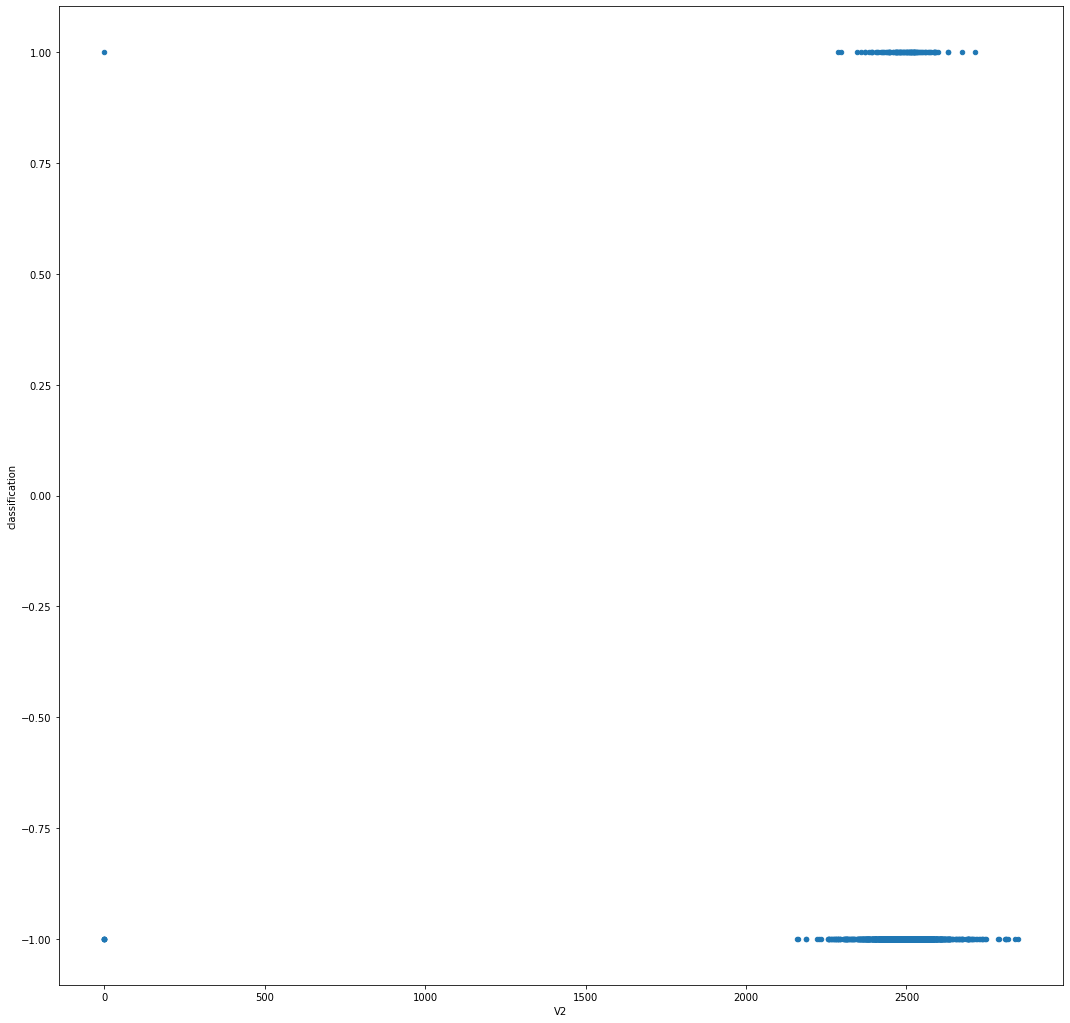

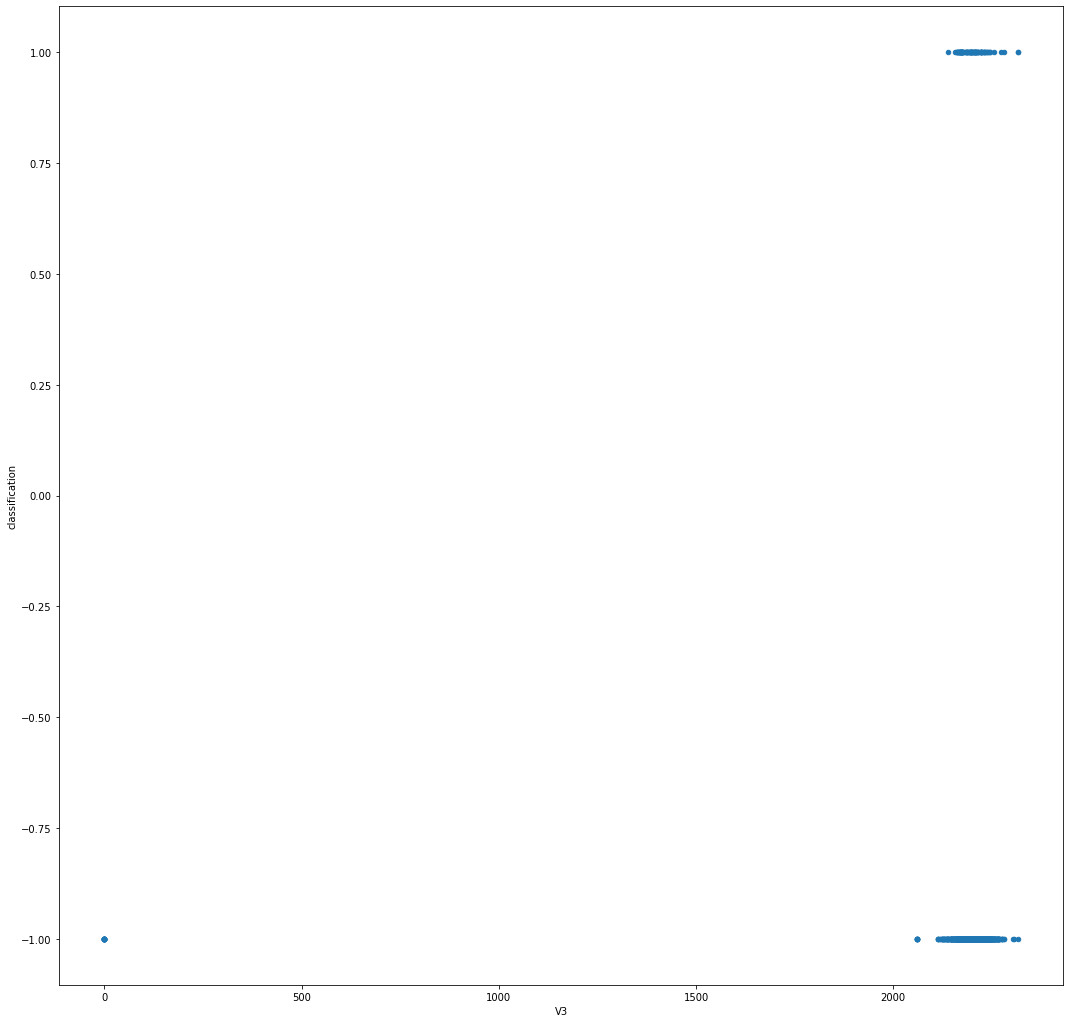

In [25]:
#fig = plt.figure(figsize=(5,5))
#plt.subplot(5,5,5)
for i in df2.columns[:3]:
  df2.plot.scatter(x=i , y='classification')

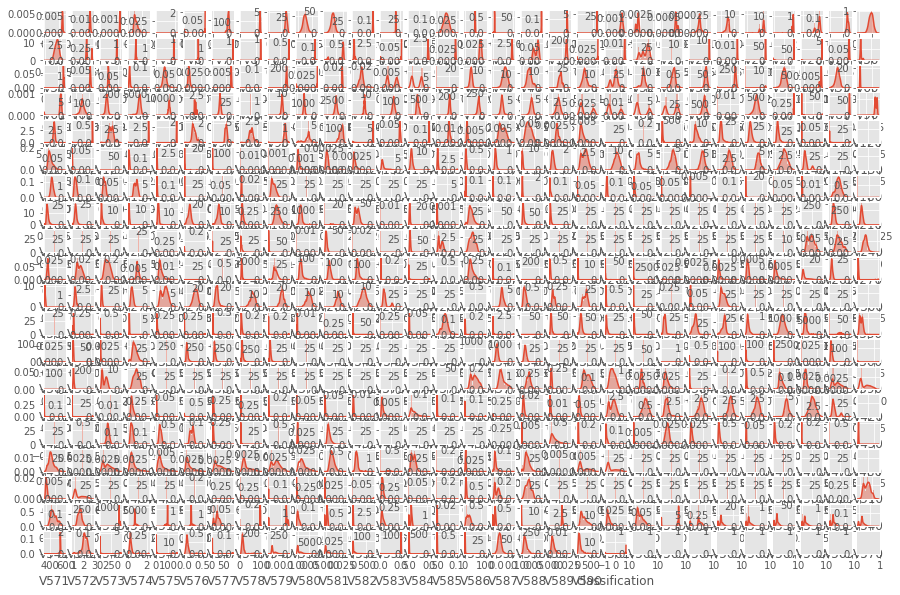

In [0]:
# Graphics
fig, axs = plt.subplots(ncols=30, nrows=20, figsize=(15, 10))
index = 0
axs = axs.flatten()
for k,v in df2.items():
    #df2.plot.scatter(x=index , y='classification')
    sns.distplot(v, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [0]:
import sklearn.preprocessing as _preproc
from lightgbm import LGBMClassifier as _LGBMClassifier
from sklearn.model_selection import cross_val_score as _cross_val_score

class DataFrameEvolution:
    def __init__(self, df):
        self.__df_raw = df
        self.__history  = _pd.DataFrame(columns = ['Step Group','Step name','LGBM CV3 ROC AUC','Comment'])

    def test(self,X,y,step_group,step_name,scoring='roc_auc'):
        lgbm = _LGBMClassifier(random_state = 0)
        score = _cross_val_score(lgbm, X, y, cv=3,scoring = scoring).mean()
        self.__history.loc[-1,['Step Group','Step name','LGBM CV3 ROC AUC']] = [step_group,step_name,score] 
        self.__history.index = self.__history.index + 1
        self.__history = self.__history.sort_index() 
        return score

    def get_history(self):
        return self.__history

    def clear_history(self):
        self.__history = _pd.DataFrame(columns = ['Step Group','Step name','LGBM CV3 ROC AUC','Comment'])

    def add_step_comment(self,step_name,comment):
        idx = self.__history[self.__history['Step name'] == step_name].index
        self.__history.at[idx, 'Comment'] = comment

    def get_step_by_name(self,step_name):
        return self.__history[self.__history['Step name'] == step_name]

    def get_step_by_group_name(self,step_group):
        return self.__history[self.__history['Step Group'] == step_group]

In [27]:
#Splitting dataframe into test and train
X = df2.iloc[:,:591]
#y = df2.iloc[:,:590]
#y = df2['classification'].copy()
y = df2['classification']
X.drop(['classification'], axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.7, random_state=10)

# show
print("shape of X       :", X.shape)
print("shape of y       :", y.shape)
print('shape of X_train :', X_train.shape[0])
print('shape of X_test  :', X_test.shape[0])
print('shape of y_train :', y_train.shape[0])
print('shape of y_test  :', y_test.shape[0])
print('shape of V       :', X_test.shape[1])

shape of X       : (1567, 590)
shape of y       : (1567,)
shape of X_train : 470
shape of X_test  : 1097
shape of y_train : 470
shape of y_test  : 1097
shape of V       : 590


In [28]:
# Check if split is actually correct
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.7, random_state=10)
score1 = float(X_test.shape[0]) / float(df.shape[0])
print('CrossValidation for split 70/30 :', score1)


CrossValidation for split 70/30 : 0.7000638162093171


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.8, random_state=10)
score2 = float(X_test.shape[0]) / float(df.shape[0])
print('CrossValidation for split 80/20 :', score2)

CrossValidation for split 80/20 : 0.8002552648372687


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.6, random_state=10)
score3 = float(X_test.shape[0]) / float(df.shape[0])
print('CrossValidation for split 60/40 :', score3)

CrossValidation for split 60/40 : 0.6005105296745373


ValueError: ignored

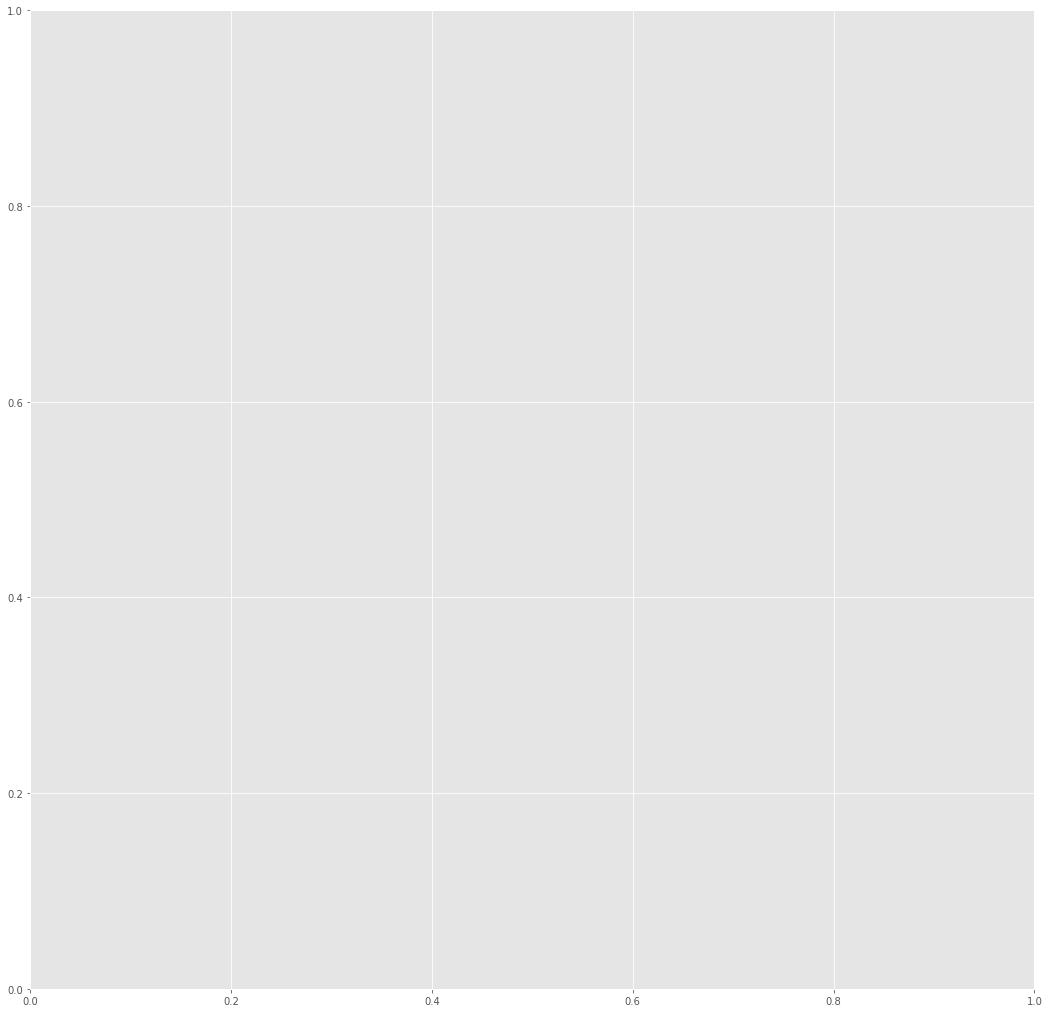

In [0]:
# Plot outputs
plt.scatter(X_test, y_test,  color='black')
plt.title('Test Data')
plt.xlabel('Fail/Pass')
plt.ylabel('Value')
plt.xticks(())
plt.yticks(())

plt.show()


In [0]:
#evo = DataFrameEvolution(df) 

In [0]:
secom = df

In [0]:
#Check out the distribution of the target variable, "classification"
secom['classification'].value_counts().plot(kind='bar')

In [0]:
# Analyzing nulls
secom_rmNa = df2
secom_rmNa.isnull().sum().sum()
secom_nulls = secom_rmNa.isnull().sum()/len(secom_rmNa)
secom_nulls.describe()
secom_nulls.hist()

In [0]:
# pie chart

labels = ['Fail', 'Pass']
size = data['classification'].value_counts()
colors = ['magenta', 'green']
explode = [0, 0.1]

plt.style.use('seaborn-deep')
plt.rcParams['figure.figsize'] = (8, 8)
plt.pie(size, labels =labels, colors = colors, explode = explode, autopct = "%.2f%%", shadow = True)
plt.axis('off')
plt.title('Target: Pass or Fail', fontsize = 20)
plt.legend()
plt.show()



In [0]:
# DummyClassifier to predict only target 0
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)

# checking unique labels
print('Unique predicted labels: ', (np.unique(dummy_pred)))

# checking accuracy
print('Test score: ', accuracy_score(y_test, dummy_pred))

In [0]:
# Modeling the data as is
# Train model
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)

# Predict on training set
lr_pred = lr.predict(X_test)

# Checking accuracy
accuracy_score(y_test, lr_pred)

In [0]:
# Checking unique values
predictions = pd.DataFrame(lr_pred)
predictions[0].value_counts()

In [0]:
from sklearn import linear_model

lm = linear_model.LinearRegression()
lm.fit(X_train, y_train)

In [0]:
lm.coef_
a = lm.predict(X_test)

In [0]:
import pandas_profiling

#pandas_profiling.ProfileReport(df2)
df2.ProfileReport()

**Under Sampling**

In [0]:
# Under Sampling
data = df2
failed_tests = np.array(data[data['classification'] == 1].index)
no_failed_tests = len(failed_tests)

print(no_failed_tests)

In [0]:
normal_indices = data[data['classification'] == -1]
no_normal_indices = len(normal_indices)

print(no_normal_indices)

In [0]:
random_normal_indices = np.random.choice(no_normal_indices, size = no_failed_tests, replace = True)
random_normal_indices = np.array(random_normal_indices)

print(len(random_normal_indices))

In [0]:
under_sample = np.concatenate([failed_tests, random_normal_indices])
print(len(under_sample))

In [0]:
# creating the undersample data

undersample_data = data.iloc[under_sample, :]



In [0]:
# splitting the undersample dataset into x and y sets

x = undersample_data.iloc[:, undersample_data.columns != 'classification'] 
y = undersample_data.iloc[:, undersample_data.columns == 'classification']

print(x.shape)
print(y.shape)

In [0]:
from sklearn.model_selection import train_test_split

x_train_us, x_test_us, y_train_us, y_test_us = train_test_split(x, y, test_size = 0.2, random_state = 0)

print(x_train_us.shape)
print(y_train_us.shape)
print(x_test_us.shape)
print(y_test_us.shape)

In [0]:
# standardization

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(x_train_us)
X_test = sc.transform(x_test_us)

In [0]:
#Xg-Boost classifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

model = XGBClassifier()
model.fit(x_train_us, y_train_us)
y_pred = model.predict(x_test_us)

In [0]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_us, y_pred)

plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.1)
sns.heatmap(cm, annot = True, annot_kws = {"size": 10})

In [0]:
print(cm)


**Observation : UnderSamling** detected 17 out of 22 defected semiconductors which is great. 



In [0]:
# Applying Grid Search CV to find the best model with the best parameters

from sklearn.model_selection import GridSearchCV

parameters = [{'max_depth' : [1, 2, 3, 4, 5, 6]}]

grid_search = GridSearchCV(estimator = model, param_grid = parameters, scoring = 'accuracy', cv = 2, n_jobs = -1)

grid_search = grid_search.fit(x_train_us, y_train_us)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

In [0]:
print("Best Accuracy: ", best_accuracy)
print("Best Parameter: ", best_parameters)

In [0]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

weights = (y == 0).sum()/(1.0*(y == -1).sum())
model = XGBClassifier(max_depth = 4, scale_pos_weights = weights, n_jobs = 4)

model.fit(x_train_us, y_train_us)

y_pred = model.predict(x_test_us)

In [0]:
# plotting the feature importances

colors = plt.cm.spring(np.linspace(0, 1, 9))
xgb.plot_importance(model, height = 1, color = colors, grid = True, importance_type = 'cover', show_values = False)

plt.rcParams['figure.figsize'] = (18, 20)
plt.xlabel('The F-Score for each values')
plt.ylabel('Importances')
plt.show()

**Over-Sampling**

In [0]:
from imblearn.over_sampling import SMOTE

x_resample, y_resample  = SMOTE().fit_sample(x, y.values.ravel())

print(x_resample.shape)
print(y_resample.shape)

In [0]:
from sklearn.model_selection import train_test_split

x_train_os, x_test_os, y_train_os, y_test_os = train_test_split(x, y, test_size = 0.2, random_state = 0)

print(x_train_os.shape)
print(y_train_os.shape)
print(x_test_os.shape)
print(y_test_os.shape)

In [0]:
# standardization
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x_train_os = sc.fit_transform(x_train_os)
x_test_os = sc.transform(x_test_os)

In [0]:
model = XGBClassifier()
model.fit(x_train_os, y_train_os)
y_pred = model.predict(x_test_os)

In [0]:
# making a parameters list
parameters = [{'max_depth' : [1, 10, 5, 7]}]

# making a grid search model
grid_search = GridSearchCV(estimator = model, param_grid = parameters, scoring = 'accuracy', cv = 2, n_jobs = -1)
grid_search = grid_search.fit(x_train_os, y_train_os)

# getting the results
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

In [0]:
print("Best Accuracy: ", best_accuracy)
print("Best Parameter: ", best_parameters)

In [0]:
weights = (y == 0).sum()/(1.0*(y == -1).sum())
model = XGBClassifier(max_depth = 10, scale_pos_weights = weights, n_jobs = 4)

model.fit(x_train_os, y_train_os)
y_pred = model.predict(x_test_os)

In [0]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_os, y_pred)

plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.0)
sns.heatmap(cm, annot = True, annot_kws = {"size": 15}, cmap = 'spring')

In [0]:
print(cm)

**Observation : OverSampling** detected 17 pieces out of 22, That is great according to accuracy.


## **III. Different Classifier** for outliers detection

**3.1. Forester**

In [0]:
#Dataset
x = df2.iloc[:, :-1]
y = df2.iloc[:, -1]
print("shape of x = ", x.shape)
print("shape of y = ", y.shape)

In [0]:
#split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

print("shape of x_train : ", x_train.shape)
print("shape of x_test  : ", x_test.shape )
print("shape of y_train : ", y_train.shape)
print("shape of y_test  : ", y_test.shape)

In [0]:
#define outliers 
Fail = df2[df2['classification']==1]
Valid = df2[df2['classification']==-1]

outliers_frac = len(Fail)/float(len(Valid))
print("Outliers : ", outliers_frac)

In [0]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(n_estimators=100, max_samples=len(x_train), 
                                       contamination=outliers_frac, random_state=0, verbose=0)
model.fit(x_train, y_train)
scores_prediction = model.decision_function(x_train)
y_pred = model.predict(x_test)

In [0]:
# printing the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, cmap = 'rainbow')

In [0]:
print(cm)

**Observation : Forest classifier** detected 11 out of 13.

**3.2. LOF**

In [0]:
from sklearn.neighbors import LocalOutlierFactor


model = LocalOutlierFactor(n_neighbors=20, algorithm='auto', leaf_size=30, metric='minkowski', p=2, 
                           metric_params=None, contamination=outliers_frac)

model.fit(x_train, y_train)
y_pred = model.fit_predict(x_test)

In [0]:
# printing the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, cmap = 'summer')

In [0]:
print(cm)

**Observation : LOF** detected 11 out of 13.

**3.3. One-Class SVM**

In [0]:
from sklearn.svm import OneClassSVM

model = OneClassSVM(kernel ='rbf', degree=3, gamma=0.1,nu=0.005, max_iter=-1, random_state=0)

model.fit(x_train, y_train)
y_pred = model.fit_predict(x_test)

In [0]:
# printing the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm ,annot = True, cmap = 'winter')

In [0]:
print(cm)

## **IV. COMPARISON**

In [0]:
Recall = np.array([77.3, 77.3, 84.6, 84.6, 61.5])
label = np.array(['UnderSampling', 'OverSampling', 'IsolationForest', 'LocalOutlier', 'OneClassSVM'])
indices = np.argsort(Recall)
color = plt.cm.rainbow(np.linspace(0, 1, 9))

plt.rcParams['figure.figsize'] = (10, 5)
plt.bar(range(len(indices)), Recall[indices], color = color)
plt.xticks(range(len(indices)), label[indices])
plt.title('Recall Accuracy', fontsize = 30)
plt.grid()
plt.tight_layout()
plt.show()

**Observation:** Forest and LOF outperforms UnderSampling and Over sampling.